In [38]:
#!pip install -U aeon
#!pip install aeon[all_extras]
import warnings
import pandas as pd
from matplotlib import pyplot as plt
from aeon.visualisation import plot_series
from all_functions import *
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb 
from sklearn.model_selection import GridSearchCV
from aeon.transformations.detrend import STLTransformer
import ast
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error, make_scorer
warnings.filterwarnings("ignore")
%matplotlib inline
def convert_to_list(series_str):
    return eval(series_str)


In [39]:
window = 12
horizon = 12
derivado = "oleodiesel"
estado = "SP"
series = read_series(f'../datasets/venda/mensal/uf/{derivado}/mensal_{estado.lower()}_{derivado}.csv')
train, test = train_test_stats(series, horizon)

transformer = STLTransformer(sp=12)  
result = transformer.fit(series)
train_resid = result.resid_
start_period = pd.Period('1993-03', freq='M')
resid = pd.concat([train_resid[start_period:], pd.Series([0,0,0,0,0,0,0,0,0,0,0,0], index=test.index)])

In [40]:
series

timestamp
1990-01     592209.401
1990-02     479283.610
1990-03     442681.406
1990-04     581878.356
1990-05     552666.028
              ...     
2023-10    1197246.395
2023-11    1171935.306
2023-12    1072537.466
2024-01     966387.502
2024-02     988435.920
Freq: M, Name: m3, Length: 410, dtype: float64

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='Tendência no tempo', ylabel='Vendas em m³'>)

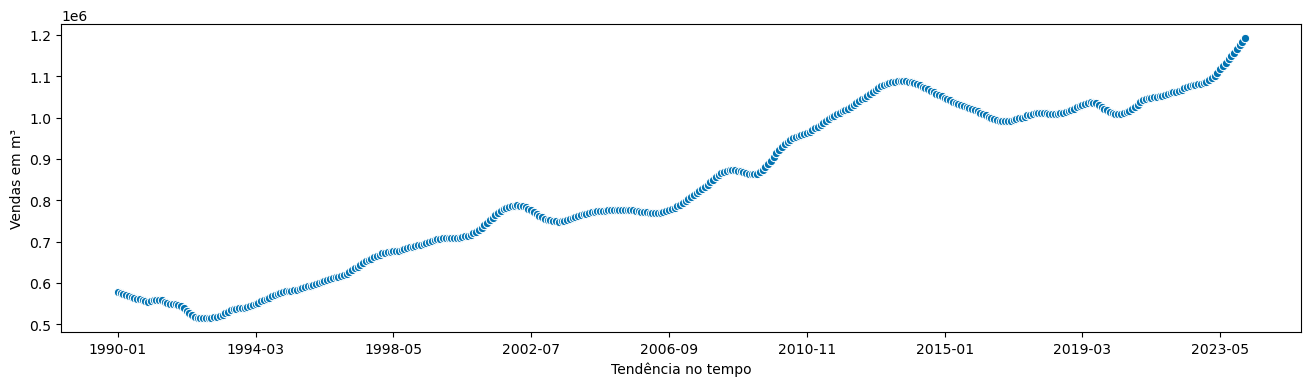

In [41]:
plot_series(result.trend_, x_label='Tendência no tempo', y_label='Vendas em m³')

In [42]:
dado = pd.read_csv(f'./results_hybrid/arima/{derivado}/normal/transform_{estado}.csv', sep=";")

filter_arima = dado[dado['test_range'] == '2023-03_2024-02']


columns_p1_to_p12 = filter_arima.loc[:, 'P1':'P12']
    
arima_preds = columns_p1_to_p12.values.flatten().tolist()        

dado['error_series'] = dado['error_series'].apply(convert_to_list)

reversed_lists = dado['error_series'].iloc[::-1]
period_index = pd.period_range(start='1993-03', end='2024-02', freq='M')
error = []
for lst in reversed_lists:
    error.extend(lst)
error_series = pd.Series(error, index=period_index)
train_error, test_error = train_test_stats(error_series, horizon)
transformer = STLTransformer(sp=12)  
result = transformer.fit(train_error)
train_error_st = result.trend_ + result.seasonal_

error_resid = error_series + resid

In [43]:
import pandas as pd
from sklearn.svm import SVR
import matplotlib.pyplot as plt

data = rolling_window(error_series, window)

data = data.dropna()
X_train, X_test, y_train, _ = train_test_split(data, horizon)

svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_rbf.fit(X_train, y_train)

predictions = recursive_multistep_forecasting(X_test, svr_rbf, horizon)
mean_norm, std_norm = get_stats_norm(error_series, horizon, window)

# Reescala as predições
predictions_rescaled = znorm_reverse(pd.Series(predictions, index=test_error.index), mean_norm, std_norm)

preds = pd.Series(predictions_rescaled, index=test_error.index)
combined = pd.Series(arima_preds + preds.values, index=test.index)
mape_result = mape(test, combined)
pbe_result = pbe(test, combined)
pocid_result = pocid(test, combined)
print_log(f'MAPE: {mape_result}')
print_log(f'PBE: {pbe_result}')
print_log(f'POCID: {pocid_result}')


[2024-08-03 17:15:54] MAPE: 0.054125347968767834

[2024-08-03 17:15:54] PBE: 3.7575214108212416

[2024-08-03 17:15:54] POCID: 81.81818181818181


In [44]:
import pandas as pd
from sklearn.svm import SVR
import matplotlib.pyplot as plt

data = rolling_window(error_resid, window)

data = data.dropna()
X_train, X_test, y_train, _ = train_test_split(data, horizon)

svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_rbf.fit(X_train, y_train)

predictions = recursive_multistep_forecasting(X_test, svr_rbf, horizon)
mean_norm, std_norm = get_stats_norm(error_resid, horizon, window)

# Reescala as predições
predictions_rescaled = znorm_reverse(pd.Series(predictions, index=test_error.index), mean_norm, std_norm)


preds_resid = pd.Series(predictions_rescaled, index=test_error.index)
combined_resid = pd.Series(arima_preds + preds_resid.values, index=test.index)
mape_result = mape(test, combined_resid)
pbe_result = pbe(test, combined_resid)
pocid_result = pocid(test, combined_resid)
print_log(f'MAPE: {mape_result}')
print_log(f'PBE: {pbe_result}')
print_log(f'POCID: {pocid_result}')


[2024-08-03 17:15:54] MAPE: 0.04319842169485769

[2024-08-03 17:15:54] PBE: 1.3937853335324446

[2024-08-03 17:15:54] POCID: 100.0


In [45]:
import pandas as pd
from sklearn.svm import SVR
import matplotlib.pyplot as plt

data = rolling_window(pd.concat([train_error_st, pd.Series([0,0,0,0,0,0,0,0,0,0,0,0], index=test.index)]), window)

data = data.dropna()
X_train, X_test, y_train, _ = train_test_split(data, horizon)

svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_rbf.fit(X_train, y_train)

predictions = recursive_multistep_forecasting(X_test, svr_rbf, horizon)
mean_norm, std_norm = get_stats_norm(pd.concat([train_error_st, pd.Series([0,0,0,0,0,0,0,0,0,0,0,0], index=test.index)]), horizon, window)

# Reescala as predições
predictions_rescaled = znorm_reverse(pd.Series(predictions, index=test_error.index), mean_norm, std_norm)


preds_noresid = pd.Series(predictions_rescaled, index=test_error.index)

combined_error_noresid = pd.Series(arima_preds + preds_noresid.values, index=test.index)
mape_result = mape(test, combined_error_noresid)
pbe_result = pbe(test, combined_error_noresid)
pocid_result = pocid(test, combined_error_noresid)
print_log(f'MAPE: {mape_result}')
print_log(f'PBE: {pbe_result}')
print_log(f'POCID: {pocid_result}')


[2024-08-03 17:15:54] MAPE: 0.050205700831984085

[2024-08-03 17:15:54] PBE: 4.237502547613939

[2024-08-03 17:15:54] POCID: 90.9090909090909


In [46]:
mape_result = mape(test, arima_preds)
pbe_result = pbe(test, arima_preds)
pocid_result = pocid(test, arima_preds)
print_log(f'MAPE: {mape_result}')
print_log(f'PBE: {pbe_result}')
print_log(f'POCID: {pocid_result}')


[2024-08-03 17:15:54] MAPE: 0.07865676061257541

[2024-08-03 17:15:54] PBE: 7.934549524665792

[2024-08-03 17:15:54] POCID: 90.9090909090909


In [47]:
# combined = pd.Series(arima_preds + preds.values, index=test.index)
# combined_resid = pd.Series(arima_preds + preds_resid.values, index=test.index)
# combined_error_noresid = pd.Series(arima_preds + preds_noresid.values, index=test.index)
arima_s = pd.Series(arima_preds, index=test.index)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='m3'>)

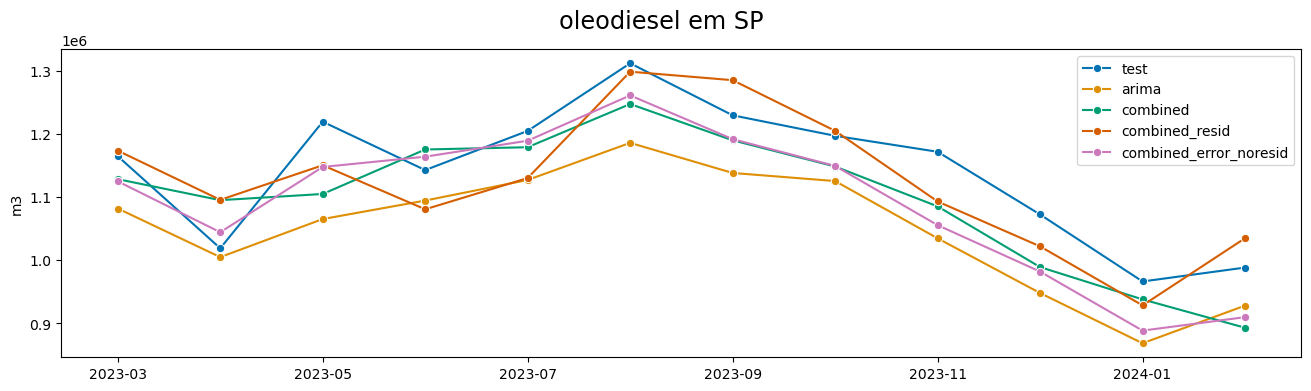

In [48]:

plot_series(test, arima_s, combined, combined_resid,combined_error_noresid, labels=['test', 'arima', 'combined', 'combined_resid', 'combined_error_noresid'], title=f'{derivado} em {estado}')